### Import libraries

In [ ]:
import os

import torch
import torch.nn as nn
import torch.fft as fft
from torch.utils.data import random_split, Dataset, DataLoader

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load data and labels

Download the data and labels from https://www.dropbox.com/sh/0r5j9ksu7gtknxp/AAC9EoWihXwNh6XJiEx_Jkr-a?dl=0 and load them into tensors.

In [ ]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/data' /content/

In [ ]:
data = torch.load('data/data.pt') # TODO load data from data/data.pt
labels = torch.load('data/labels.pt') # TODO load labels from data/labels.pt

In [ ]:
data.shape

torch.Size([10, 65, 50176])

How many channels (i.e. sensors on the EEG cap) does one EEG recording have? How long was the recording time if the sampling frequency was fs=250Hz?

What is the maximum frequency that can be detected when the sampling frequency is fs=250Hz? (Hint: check out Nyquist frequency)

In [ ]:
from typing import FrozenSet
nb_channels = data.shape[1] # TODO
print(f"Nb channels in a recording: {nb_channels}")

fs = 250
rec_time = data.shape[2] / fs # TODO
print(f"Recording time: {rec_time} sec")

max_f = 0.5 * fs # TODO
print(f"Maximum frequency to be detected: {max_f} Hz")

Nb channels in a recording: 65
Recording time: 200.704 sec
Maximum frequency to be detected: 125.0 Hz


How many subjects are included in the dataset? How many different classes are present in the dataset? 

In [ ]:
nb_subjects = labels.shape[0] # TODO 
print(f"Nb subjects in the dataset: {nb_subjects}")

nb_classes = labels.shape[1] # TODO
print(f"Nb classes in the dataset: {nb_classes}")

Nb subjects in the dataset: 10
Nb classes in the dataset: 2


### Compute power spectral density (PSD)

Let x_t contain the second subject's EEG signal from channel 23. 

Initialize a new variable t containing the recording time in seconds.

In [ ]:
fs = 250 # sampling frequency

subject = 1
channel = 22
x_t = data[subject][channel]

N = len(x_t)
t = torch.arange(start = 0, end = rec_time, step = 1/fs) # TODO

Plot the EEG signal and the corresponding PSD. (Hint: check out matplotlib.pyplot.psd()) Let NFFT be 1024. Choose the sampling frequency as given above. 

Was the data recorded in Europe or the United States of America?

**Answer** : Europe - Interference is at 50 Hz

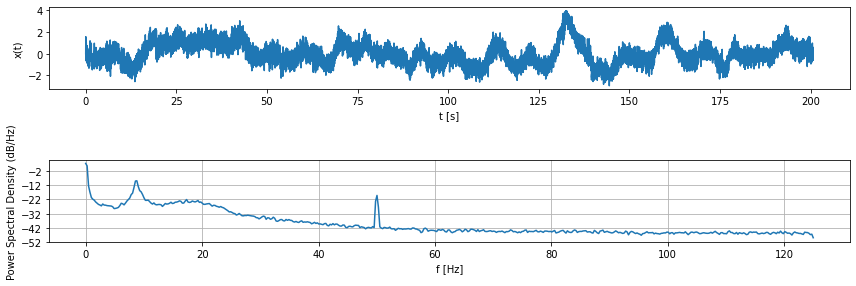

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(211)
plt.plot(t, x_t)
plt.xlabel('t [s]')
plt.ylabel('x(t)')

plt.subplot(212)
plt.psd(x_t, NFFT=1024, Fs=fs) # TODO
plt.xlabel('f [Hz]')

plt.tight_layout()
plt.show()

### Remove artifacts using Fourier transform 

Plot the Fourier spectrum of the EEG recording. (Hint: check out torch.fft.fft() and torch.fft.fftshift())

Note that the Fourier spectrum of a real signal (no imaginary term) is symmetric, i.e. it contains negativ as well as positive frequencies, and is continous over f. Moreover, consider the maximum frequency that can be detected (Nyquist frequency).

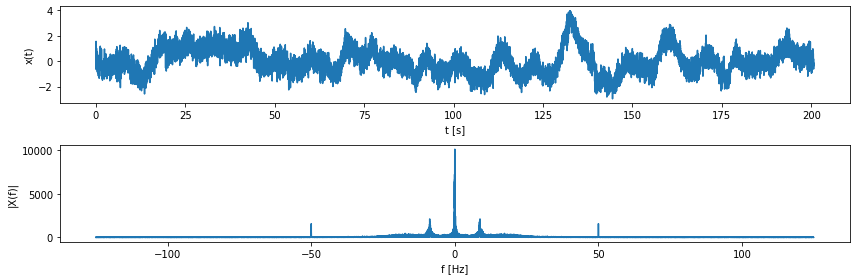

In [ ]:
Y = torch.fft.fftshift(torch.fft.fft(x_t)) # TODO determine the fourier spectrum of x_t

N = len(x_t)
f = torch.arange(start = -max_f, end =  max_f, step = fs/N) # TODO

plt.figure(figsize=(12, 4))

plt.subplot(211)
plt.plot(t, x_t)
plt.xlabel('t [s]')
plt.ylabel('x(t)')

plt.subplot(212)
plt.plot(f, torch.abs(Y))
plt.xlabel('f [Hz]')
plt.ylabel('|X(f)|')

plt.tight_layout()
plt.show()

Remove the line noise frequency with a two-sided margin of 1Hz and plot the new Fourier spectrum. 

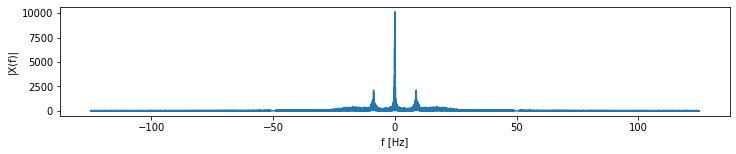

In [ ]:
Y_band_stop = Y.clone()

mask = (abs(f) >= 49) & (abs(f) <= 51 )
indices = mask.nonzero()
Y_band_stop[indices]=0 # TODO apply band stop filter to remove line noise

plt.figure(figsize=(12, 2))
plt.plot(f, torch.abs(Y_band_stop))
plt.xlabel('f [Hz]')
plt.ylabel('|X(f)|')
plt.show()

Synthesize the signal, which is now denoised, from the Fourier spectrum and plot it. (Hint: check out torch.fft.ifft() and torch.fft.ifftshift())

Note that the original signal was containing only real parts. Make sure this also holds after the synthesis. 

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:734: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


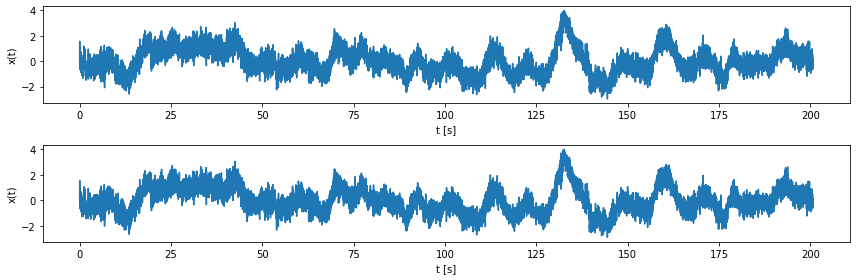

In [ ]:
x_t_denoised =  torch.fft.ifft(torch.fft.ifftshift(Y_band_stop)) # TODO apply fourier synthesis to the denoised Fourier spectrum

plt.figure(figsize=(12, 4))

plt.subplot(211)
plt.plot(t, x_t)
plt.xlabel('t [s]')
plt.ylabel('x(t)')

plt.subplot(212)
plt.plot(t, x_t_denoised)
plt.xlabel('t [s]')
plt.ylabel('x(t)')

plt.tight_layout()
plt.show()

### Perform some data augmentations

Add some jitter to the data. Assume the jitter to be gaussian noise with mean=0 and std=0.3. Plot the new signal.

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:734: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


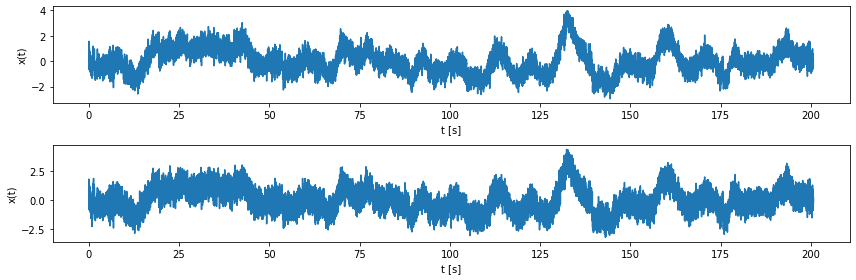

In [ ]:
import numpy as np
mu = 0
sigma = 0.3

jitter = np.random.normal(loc=mu, scale=sigma, size=len(x_t_denoised)) # TODO 

x_t_noisy = x_t_denoised + jitter

plt.figure(figsize=(12, 4))

plt.subplot(211)
plt.plot(t, x_t)
plt.xlabel('t [s]')
plt.ylabel('x(t)')

plt.subplot(212)
plt.plot(t, x_t_noisy)
plt.xlabel('t [s]')
plt.ylabel('x(t)')

plt.tight_layout()
plt.show()

Randomly rescale the data. Assume the rescaling factor to be normally distributed with mean=1 and std=0.1. Plot the new signal.

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:734: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


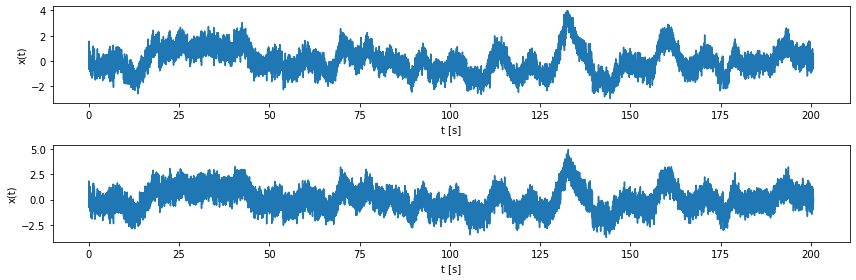

In [ ]:
mu = 1
sigma = 0.1

rescaling = np.random.normal(mu,sigma,x_t_denoised.shape) # TODO

x_t_scaled = x_t_noisy * rescaling

plt.figure(figsize=(12, 4))

plt.subplot(211)
plt.plot(t, x_t)
plt.xlabel('t [s]')
plt.ylabel('x(t)')

plt.subplot(212)
plt.plot(t, x_t_scaled)
plt.xlabel('t [s]')
plt.ylabel('x(t)')

plt.tight_layout()
plt.show()

### Build a shallow CNN

Define the dataset.

In [ ]:
import numpy as np
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
class EEGDataset(Dataset):
    """Fast EEGDataset (fetching prepared data and labels from files)"""
    def __init__(self, augment=False) -> None:
        """load data and labels from files"""
        data_file = f'data.pt'
        labels_file = f'labels.pt'

        self.augment = augment

        self.data = torch.load(os.path.join(os.getcwd(), 'data', data_file), 
                                map_location=torch.device('cpu')) # load to ram
        self.labels = torch.load(os.path.join(os.getcwd(), 'data', labels_file), 
                                map_location=torch.device('cpu')) # load to ram

    def __len__(self) -> int:
        """return the number of samples in the dataset"""
        return len(self.labels)

    def __getitem__(self, idx):
        """return a sample from the dataset at index idx"""
        data, label = self.data[idx], self.labels[idx]
        if self.augment == True:
            # here you can add some data augmentation 
            noise = np.random.normal(loc=0, scale=0.3, size=data.shape)
            data = data + noise

            rescaling = np.random.normal(1,0.1,x_t_denoised.shape) # TODO

            data = data * rescaling
            data = data.float()

        return data, label

Load the dataset and randomly split it into train (75% of the data) and test (25% of the data) set.

In [ ]:
from torch.utils.data import random_split
dataset = EEGDataset(augment = False)

# split into training and test set
train_len = int(0.75 * len(dataset)) # TODO
test_len = len(dataset) - train_len # TODO

print(train_len, test_len)
train_data, test_data = random_split(dataset, [train_len, test_len])

7 3


Create a train and a test dataloader. Let the batch size be 4. Shuffle the data for training. 

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True) # TODO
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=False) # TODO

Build the network

Add another convolutional layer with out_channels=256, kernel_size=9, and stride=4. Choose the padding such that the L_out=784. (Hint: checkout the pytorch documentary for Conv1d)

Add a dropout layer.

Add a fully connected linear layer with output dimensions equally to the number of classes.

In [ ]:
class ConvNet_1d(nn.Module):
    """Convolutional network with 4 layers"""
    def __init__(self, dropout=0.50, num_classes=2) -> None:
        super().__init__()
        self.conv1 = nn.Conv1d(65, 128, kernel_size=49, stride=4, padding=24)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=9, stride=4, padding=4)

        self.conv2 = nn.Conv1d(128, 256, kernel_size=9, stride=4, padding=3) # TODO
        self.bn2 = nn.BatchNorm1d(256) # TODO

        self.dropout = nn.Dropout(dropout) # TODO

        self.fc = nn.Linear(256, num_classes) # TODO
    

    def forward(self, x) -> torch.Tensor:
        # conv

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        a = self.maxpool(out)

        out = self.conv2(a)
        out = self.bn2(out)
        b = self.relu(out)
        #print(b.shape)
        # global average pooling
        c = b.mean(axis=-1)

        # dropout
        d = self.dropout(c)
        #print(d.shape)

        # fc
        out = self.fc(d)

        return out

Define the model to be ConvNet_1d, the optimizer to be Adam with a learning rate of 3e-4 and a weight decay of 1e-4, and the criterion to be cross entropy. 

In [ ]:
from torchsummary import summary

In [ ]:
model = ConvNet_1d() # TODO
summary(model, (65, 50176))

optimizer = torch.optim.Adam(model.parameters(),lr=3e-4, weight_decay=1e-4) # TODO
criterion = torch.nn.CrossEntropyLoss(reduction='mean') # TODO

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [-1, 128, 12544]         407,808
       BatchNorm1d-2           [-1, 128, 12544]             256
              ReLU-3           [-1, 128, 12544]               0
         MaxPool1d-4            [-1, 128, 3136]               0
            Conv1d-5             [-1, 256, 784]         295,168
       BatchNorm1d-6             [-1, 256, 784]             512
              ReLU-7             [-1, 256, 784]               0
           Dropout-8                  [-1, 256]               0
            Linear-9                    [-1, 2]             514
Total params: 704,258
Trainable params: 704,258
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 12.44
Forward/backward pass size (MB): 44.41
Params size (MB): 2.69
Estimated Total Size (MB): 59.54
----------------------------------------

Initialize the training script.

In [ ]:
def train(dataloader, model, criterion, optimizer):
    model.train()
    running_acc, running_loss = 0.0, 0.0
    for X, y in dataloader:
        y_pred = model(X)
        loss = criterion(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_acc += (y_pred.argmax(dim=-1) == y.argmax(dim=-1)).sum()
        running_loss += loss.item()

    nb_samples = len(dataloader.dataset)
    nb_batches = len(dataloader)

    running_acc /= nb_samples
    running_loss /= nb_batches

    print(f"Train accuracy: {(100*running_acc):>0.1f}%, Train loss: {running_loss:>8f}")

Initialize the testing script

In [ ]:
def test(dataloader, model, criterion):
    model.eval()
    acc, loss = 0.0, 0.0
    with torch.no_grad():
        for X, y in dataloader:
            y_pred = model(X)
            loss += criterion(y_pred, y).item()
            acc += (y_pred.argmax(dim=-1) == y.argmax(dim=-1)).sum()

    nb_samples = len(dataloader.dataset)
    nb_batches = len(dataloader)

    acc /= nb_samples
    loss /= nb_batches

    print(f"Test accuracy: {(100*acc):>0.1f}%, Test loss: {loss:>8f}\n")

Train the model for 10 epochs. What does the training curve tell about your network? 

**Answer**:

The values of training loss reduces with epochs and the model achieves 100% accuracy. However, the test accuracy is high, indicates that the model is overfitting.


In [ ]:
## Without augmentation
epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # TODO
    train(train_dataloader,model, criterion, optimizer)



Epoch 1
-------------------------------
Train accuracy: 71.4%, Train loss: 0.653433
Epoch 2
-------------------------------
Train accuracy: 42.9%, Train loss: 0.675254
Epoch 3
-------------------------------
Train accuracy: 71.4%, Train loss: 0.541660
Epoch 4
-------------------------------
Train accuracy: 85.7%, Train loss: 0.391445
Epoch 5
-------------------------------
Train accuracy: 100.0%, Train loss: 0.260582
Epoch 6
-------------------------------
Train accuracy: 85.7%, Train loss: 0.424889
Epoch 7
-------------------------------
Train accuracy: 100.0%, Train loss: 0.117999
Epoch 8
-------------------------------
Train accuracy: 100.0%, Train loss: 0.083695
Epoch 9
-------------------------------
Train accuracy: 100.0%, Train loss: 0.077471
Epoch 10
-------------------------------
Train accuracy: 100.0%, Train loss: 0.076673


In [ ]:
test(test_dataloader,model, criterion)

Test accuracy: 100.0%, Test loss: 0.284539



In [ ]:
## With augmentation
dataset = EEGDataset(augment = True)

train_data, test_data = random_split(dataset, [train_len, test_len])
model = ConvNet_1d() # TODO
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True) # TODO
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=False) # TODO

optimizer = torch.optim.Adam(model.parameters(),lr=3e-4, weight_decay=1e-4) # TODO
criterion = torch.nn.CrossEntropyLoss(reduction='mean') # TODO

In [ ]:
epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # TODO
    train(train_dataloader,model, criterion, optimizer)


Epoch 1
-------------------------------
Train accuracy: 14.3%, Train loss: 0.839768
Epoch 2
-------------------------------
Train accuracy: 85.7%, Train loss: 0.492958
Epoch 3
-------------------------------
Train accuracy: 100.0%, Train loss: 0.431955
Epoch 4
-------------------------------
Train accuracy: 85.7%, Train loss: 0.434657
Epoch 5
-------------------------------
Train accuracy: 42.9%, Train loss: 0.736561
Epoch 6
-------------------------------
Train accuracy: 71.4%, Train loss: 0.509599
Epoch 7
-------------------------------
Train accuracy: 100.0%, Train loss: 0.195888
Epoch 8
-------------------------------
Train accuracy: 100.0%, Train loss: 0.185616
Epoch 9
-------------------------------
Train accuracy: 100.0%, Train loss: 0.131227
Epoch 10
-------------------------------
Train accuracy: 71.4%, Train loss: 0.409532


In [ ]:
test(test_dataloader,model, criterion)

Test accuracy: 100.0%, Test loss: 0.219756



**Observations**

With augmentation, we see that the training loss does not decrease to a value similar to without augmentation. This shows that augmentation is making the training a little harder. 

However, the model still overfits.